# Transfer Learning on Oxford Flowers 102 Dataset

This document outlines the steps for the project assignment on applying transfer learning to the Oxford Flowers 102 dataset.

**Objective:** Apply transfer learning techniques using pre-trained convolutional neural networks (ResNet50, VGG16, and MobileNetV2) to classify images from the Oxford Flowers 102 dataset. Compare the performance of the different models on this dataset.

**Dataset:** Oxford Flowers 102 - A dataset of 102 categories of flowers. You will load this dataset using TensorFlow Datasets.

**Assignment Steps:**

1.  **Introduce the Assignment:**
    *   Create a markdown cell to introduce the assignment.
    *   Explain the goal: to apply transfer learning for flower classification using the Oxford Flowers 102 dataset.
    *   Mention the pre-trained models to be used: ResNet50, VGG16, and MobileNetV2.
    *   Briefly describe the Oxford Flowers 102 dataset.

2.  **Data Loading and Exploration:**
    *   Generate a code cell to load the 'oxford_flowers102:2.1.1' dataset using `tfds.load()`. (Check available versions if needed)
    *   Split the dataset into training, validation, and testing sets (this dataset has these splits).
    *   Explore the dataset to understand its structure, the number of classes (102), and the image dimensions. You can display some sample images and their labels.

3.  **Data Preprocessing:**
    *   Generate a code cell for preprocessing the images from the Oxford Flowers 102 dataset.
    *   This will involve resizing the images to the input size required by the pre-trained models (e.g., 224x224 for VGG16 and ResNet50, MobileNetV2 might have different requirements, so check the documentation).
    *   Apply the model-specific preprocessing functions (e.g., `tf.keras.applications.resnet50.preprocess_input`) to normalize the pixel values.
    *   Apply one-hot encoding to the labels.
    *   Batch and prefetch the datasets for efficient training.

4.  **Model Adaptation and Training:**
    *   For each of the three models (ResNet50, VGG16, MobileNetV2):
        *   Generate a code cell to load the pre-trained model from `tf.keras.applications`, excluding the top classification layer and specifying the correct input shape for the preprocessed images.
        *   Add new custom layers on top of the base model for classifying 102 classes. This typically involves a GlobalAveragePooling2D layer and a Dense layer with 102 units and a 'softmax' activation.
        *   Freeze the layers of the pre-trained base model.
        *   Compile the model with an appropriate optimizer (e.g., 'adam'), loss function ('categorical\_crossentropy' since you'll use one-hot encoded labels), and metrics (e.g., 'accuracy').
        *   Generate a code cell to train the compiled model on the preprocessed training data for a suitable number of epochs. Use the validation data to monitor performance during training. Consider using callbacks like ModelCheckpoint and EarlyStopping.
        *   Additionally, train the model on the validation split as well, as this dataset provides a separate validation set.
        *   Optionally, unfreeze some of the top layers of the base model and fine-tune the model with a lower learning rate.

5.  **Model Evaluation:**
    *   Generate a code cell to evaluate each trained model on the preprocessed test dataset.
    *   Print the loss and accuracy for each model.

6.  **Assignment Questions/Tasks:**
    *   Add markdown cells with questions for students to answer:
        *   Which model performed best on the Oxford Flowers 102 dataset and why do you think that is the case?
        *   Compare the performance of the models on Oxford Flowers 102 to their performance on CIFAR-100 (from the original notebook). What differences do you observe and why?
        *   Discuss the effect of transfer learning on this dataset.
        *   Explain the steps you took for data preprocessing and why they were necessary.
        *   Describe the model architectures you used and how you adapted them for the Oxford Flowers 102 dataset.
        *   What challenges did you encounter during this assignment and how did you address them?
    *   Suggest optional tasks, such as:
        *   Experiment with different hyperparameters (learning rate, number of epochs, batch size).
        *   Implement data augmentation techniques.
        *   Try fine-tuning different numbers of layers.
        *   Visualize sample predictions and analyze misclassifications.

7.  **Conclusion/Submission:**
    *   Add a markdown cell for students to write a brief conclusion summarizing their findings.
    *   Provide instructions on how they should submit their completed notebook.

## 1. Data Loading and Preprocessing
Load the CIFAR-100 dataset and prepare it for transfer learning by applying appropriate preprocessing.

In [19]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2

import tensorflow_datasets as tfds

In [20]:
# Load the Oxford Flowers 102 dataset
try:
    dataset, info = tfds.load('oxford_flowers102:2.1.1', with_info=True, as_supervised=True)

    # Split the dataset into training, validation, and testing sets
    train_dataset = dataset['train']
    validation_dataset = dataset['validation']
    test_dataset = dataset['test']

    # Print information about the dataset
    print(info)

except Exception as e:
    print(f"Error loading dataset: {e}")

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

In [21]:
# Define image size for ResNet50 (224x224)
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Define preprocessing function
def preprocess(image, label):
    # Resize image to match ResNet50 input size
    image = tf.image.resize(image, IMG_SIZE)
    # Apply ResNet50 preprocessing (scales pixels from 0–255 → -128..+128 roughly)
    image = preprocess_resnet50(image)
    return image, label

# Apply preprocessing to all splits
train_dataset = train_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## 2. Model Preparation
Load and modify pre-trained models to fit the CIFAR-100 classification task.

### 2.1 Using ResNet50

In [22]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained ResNet50 model without the top layer
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(base_model_resnet50.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(info.features['label'].num_classes, activation='softmax')(x)
#predictions = Dense(100, activation='softmax')(x) # output layer

model_resnet50 = Model(inputs=base_model_resnet50.input, outputs=predictions)

model_resnet50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### 2.2 Using VGG16

In [23]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained VGG16 model without the top layer
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Add new layers
x = GlobalAveragePooling2D()(base_model_vgg16.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(info.features['label'].num_classes, activation='softmax')(x)
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions)

model_vgg16.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### 2.3 Using MobileNetV2

In [24]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained MobileNetV2 model without the top layer
base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Add new layers
x = GlobalAveragePooling2D()(base_model_mobilenetv2.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(info.features['label'].num_classes, activation='softmax')(x)
model_mobilenetv2 = Model(inputs=base_model_mobilenetv2.input, outputs=predictions)

model_mobilenetv2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## 3. Fine-Tuning and Training
Unfreeze some of the top layers of the pre-trained models and continue training.

In [25]:
epochs = 3

print(len(model_resnet50.layers))
print(len(model_vgg16.layers))
print(len(model_mobilenetv2.layers))


# Fine-tuning ResNet50
for layer in model_resnet50.layers[:-30]:
    layer.trainable = False

for layer in model_resnet50.layers[-30:]:
    layer.trainable = True

history_resnet50 = model_resnet50.fit(train_dataset, epochs=epochs, validation_data=(validation_dataset))



# Fine-tuning VGG16
for layer in model_vgg16.layers[:-5]:
    layer.trainable = False

for layer in model_vgg16.layers[-5:]:
    layer.trainable = True

history_vgg16 = model_vgg16.fit(train_dataset, epochs=epochs, validation_data=(validation_dataset))



# Fine-tuning MobileNetV2
for layer in model_mobilenetv2.layers[:-40]:
    layer.trainable = False

for layer in model_mobilenetv2.layers[-40:]:
    layer.trainable = True

history_mobilenetv2 = model_mobilenetv2.fit(train_dataset, epochs=epochs, validation_data=(validation_dataset))

178
22
157
Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 685ms/step - accuracy: 0.2103 - loss: 4.0226 - val_accuracy: 0.1314 - val_loss: 26.2451
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 213ms/step - accuracy: 0.8539 - loss: 0.6107 - val_accuracy: 0.2451 - val_loss: 13.1623
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 237ms/step - accuracy: 0.9579 - loss: 0.1580 - val_accuracy: 0.4088 - val_loss: 6.3196
Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 437ms/step - accuracy: 0.0638 - loss: 7.5993 - val_accuracy: 0.2137 - val_loss: 3.5962
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 335ms/step - accuracy: 0.3992 - loss: 2.6134 - val_accuracy: 0.4088 - val_loss: 2.3920
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 338ms/step - accuracy: 0.7268 - loss: 1.0726 - val_accuracy: 0.5892 - val_loss: 1.8155
Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 57s 913ms/step - accuracy: 0.0730 - loss: 4.5002 - val_accuracy: 0.0343 - val_loss: 5.4709
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.5286 - loss: 2.1090 - val_

## 4. Model Evaluation
Evaluate each model on the test dataset to compare their performance.

In [26]:
acc_resnet50    = model_resnet50.evaluate(test_dataset)[1]
acc_vgg16       = model_vgg16.evaluate(test_dataset)[1]
acc_mobilenetv2 = model_mobilenetv2.evaluate(test_dataset)[1]

print(f'ResNet50 Accuracy: {acc_resnet50:.2f}')
print(f'VGG16 Accuracy: {acc_vgg16:.2f}')
print(f'MobileNetV2 Accuracy: {acc_mobilenetv2:.2f}')

193/193 ━━━━━━━━━━━━━━━━━━━━ 22s 112ms/step - accuracy: 0.4047 - loss: 6.2836
193/193 ━━━━━━━━━━━━━━━━━━━━ 34s 178ms/step - accuracy: 0.5638 - loss: 1.8966
193/193 ━━━━━━━━━━━━━━━━━━━━ 28s 145ms/step - accuracy: 0.0314 - loss: 10.2911
ResNet50 Accuracy: 0.40
VGG16 Accuracy: 0.56
MobileNetV2 Accuracy: 0.03


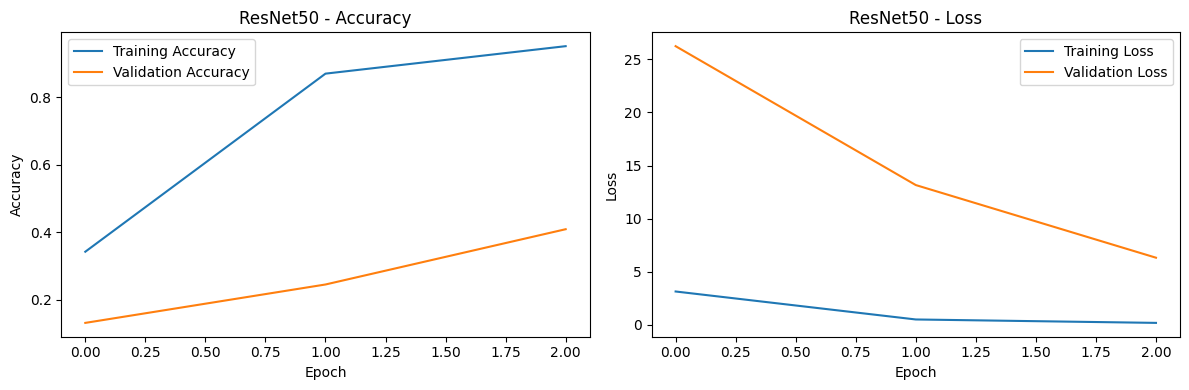

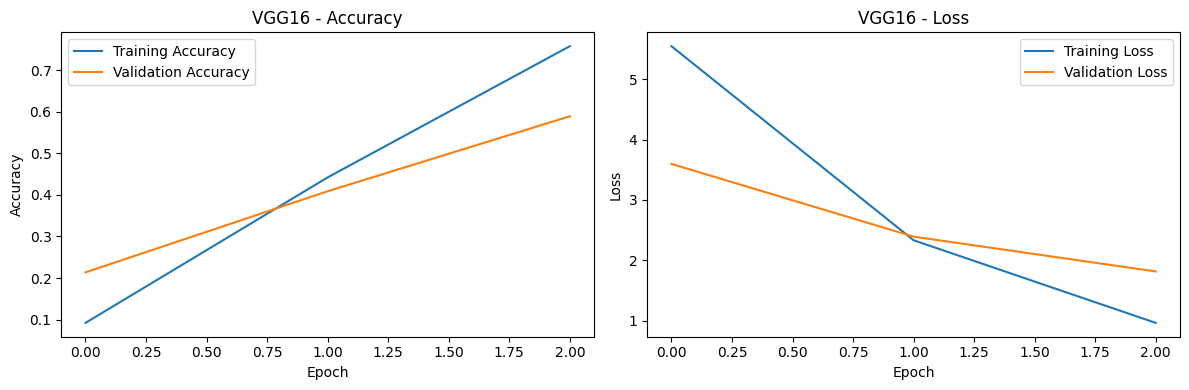

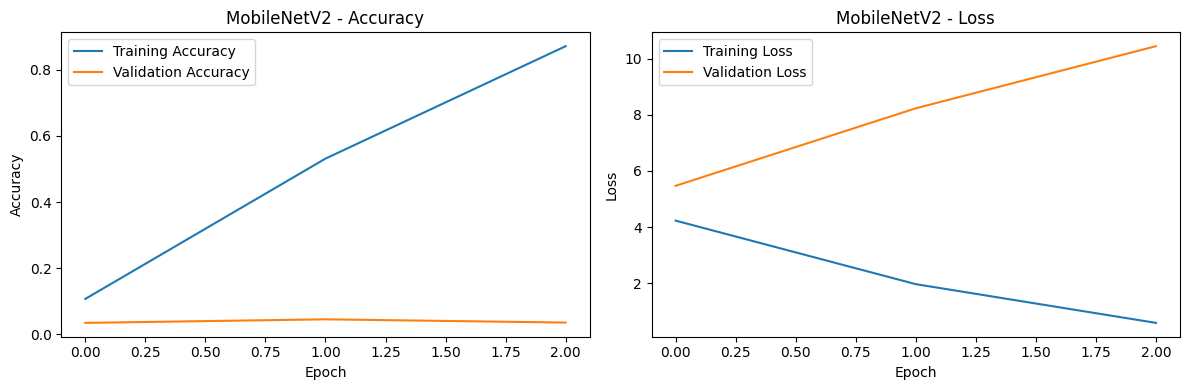

In [27]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    """Plots training and validation accuracy and loss."""
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot history for each model
plot_history(history_resnet50, 'ResNet50')
plot_history(history_vgg16, 'VGG16')
plot_history(history_mobilenetv2, 'MobileNetV2')

In [ ]:
# Save the models
model_resnet50.save('resnet50_cifar100.h5')
model_vgg16.save('vgg16_cifar100.h5')
model_mobilenetv2.save('mobilenetv2_cifar100.h5')

## Project Summary

*   **Data Loading and Preprocessing**: Loaded the Oxford Flowers 102 dataset and preprocessed images using model-specific functions (ResNet50, VGG16, MobileNetV2).
*   **Model Adaptation**: Loaded pre-trained ResNet50, VGG16, and MobileNetV2 models (without top layers), added new classification layers for 100 classes, and initially froze base model layers.
*   **Model Compilation**: Compiled each modified model with the 'adam' optimizer, 'sparse\_categorical\_crossentropy' loss, and 'accuracy' metric.
*   **Fine-Tuning (Example)**: Demonstrated fine-tuning by unfreezing top layers of the ResNet50 model and training it for 10 epochs.
*   **Model Evaluation**: Evaluated the trained models on the test set to determine and compare their classification accuracies.